# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [3]:
df = pd.read_csv('../Data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


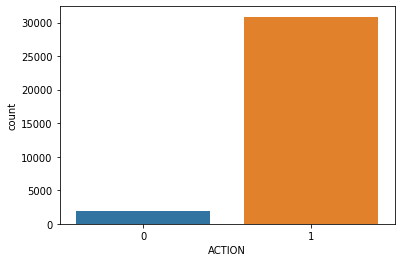

In [4]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [5]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [6]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [8]:
knc = KNeighborsClassifier(n_neighbors=5, p=2)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



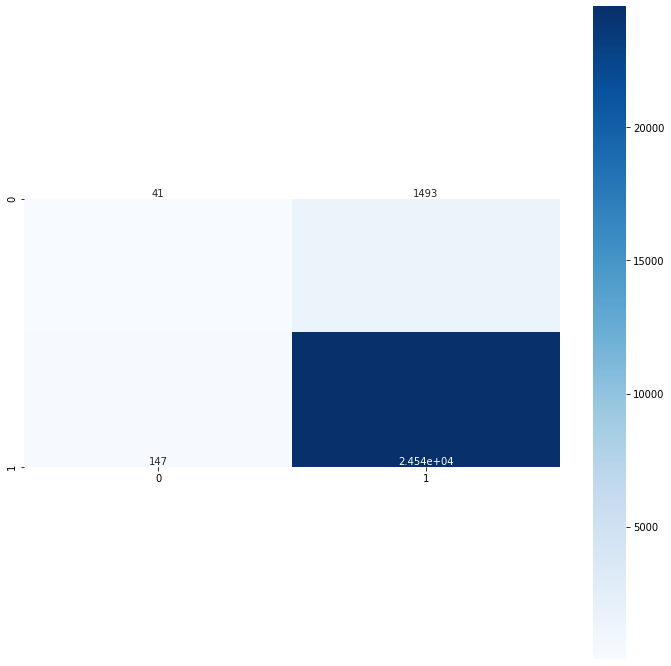

In [9]:
akws = {"ha": 'center',"va": 'bottom'}
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g', annot_kws=akws)

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
params = {
    "n_neighbors": [10], 
    "p": [1,2,4,6]
}

search = GridSearchCV(KNeighborsClassifier(), params, n_jobs=2, 
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), verbose=2)
%time search.fit(X, y)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [11]:
print("Best p={}".format(search.best_params_['p']))
index = search.param_grid['p'].index(search.best_params_['p'])
print("mean_test_score={}".format(search.cv_results_['mean_test_score'][index]))
print("std_test_score={}".format(search.cv_results_['std_test_score'][index]))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [12]:
data = pd.DataFrame(index=df.index)
for col_name in df.columns:
    if col_name == 'ACTION':
        continue
    # ТУТ ВАШ КОД
    counts = df.groupby(col_name).count()['ACTION']
    successes = df.groupby(col_name).sum()['ACTION']
    data[col_name+'_counts'] = df[col_name].apply(lambda x: counts[x])
    data[col_name+'_successes'] = df[col_name].apply(lambda x: successes[x])
    data[col_name+'_c/s'] = (data[col_name+'_successes'] + 1) / (data[col_name+'_counts'] + 2)
    
data

,RESOURCE_counts,RESOURCE_successes,RESOURCE_c/s,MGR_ID_counts,MGR_ID_successes,MGR_ID_c/s,ROLE_ROLLUP_1_counts,ROLE_ROLLUP_1_successes,ROLE_ROLLUP_1_c/s,ROLE_ROLLUP_2_counts,...,ROLE_TITLE_c/s,ROLE_FAMILY_DESC_counts,ROLE_FAMILY_DESC_successes,ROLE_FAMILY_DESC_c/s,ROLE_FAMILY_counts,ROLE_FAMILY_successes,ROLE_FAMILY_c/s,ROLE_CODE_counts,ROLE_CODE_successes,ROLE_CODE_c/s
0,3,3,0.800000,55,55,0.982456,21407,20320,0.949180,4424,...,0.967364,6896,6437,0.933314,10980,10347,0.942269,3583,3467,0.967364
1,30,29,0.937500,10,10,0.916667,21407,20320,0.949180,3945,...,0.951807,12,12,0.928571,1287,1220,0.947246,81,78,0.951807
2,2,2,0.750000,3,3,0.800000,184,169,0.913978,184,...,0.888712,33,31,0.914286,2636,2393,0.907506,1256,1117,0.888712
3,1,1,0.666667,62,62,0.984375,21407,20320,0.949180,3945,...,0.920232,1244,1189,0.955056,10980,10347,0.942269,4649,4279,0.920232
4,8,8,0.900000,9,9,0.909091,276,257,0.928058,138,...,0.857143,19,18,0.904762,362,303,0.835165,75,65,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,51,46,0.886792,29,28,0.935484,21407,20320,0.949180,4424,...,0.920232,1244,1189,0.955056,10980,10347,0.942269,4649,4279,0.920232
32765,2,2,0.750000,9,9,0.909091,721,695,0.962656,721,...,0.961538,5,5,0.857143,224,219,0.973451,24,24,0.961538
32766,161,155,0.957055,5,5,0.857143,21407,20320,0.949180,2641,...,0.800000,2,2,0.750000,78,76,0.962500,3,3,0.800000
32767,7,7,0.888889,16,11,0.666667,275,202,0.732852,257,...,0.911616,244,210,0.857724,1318,1137,0.862121,394,360,0.911616


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [11]:
from sklearn.model_selection import cross_val_score
X = data
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)
res = cross_val_score(KNeighborsClassifier(n_neighbors=5, p=2), X, y, cv=5)
res.mean(), res.std()

(0.9471755211248818, 0.001448333363661077)

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

In [12]:
knc = KNeighborsClassifier(n_neighbors=5, p=2)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.11      0.17      1534
           1       0.95      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.71      0.55      0.57     26216
weighted avg       0.92      0.94      0.92     26216



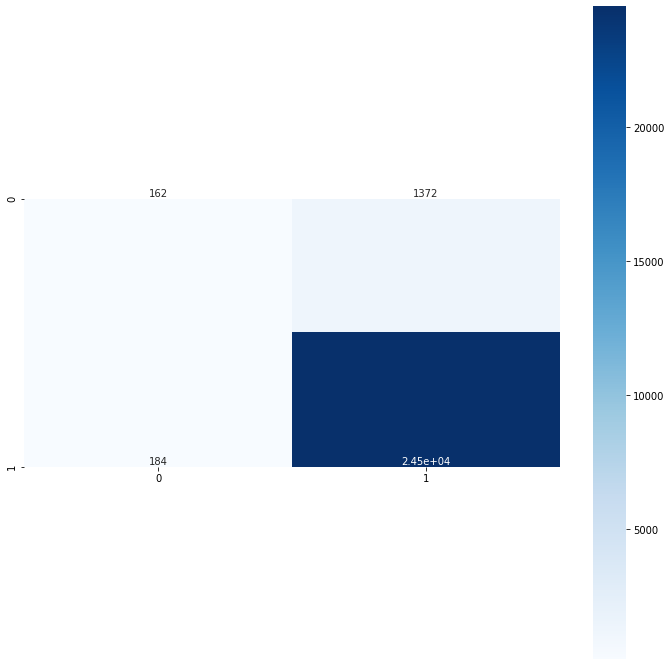

In [13]:
akws = {"ha": 'center',"va": 'bottom'}
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g', annot_kws=akws)

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [13]:
df_combo = df.copy()
columns = df_combo.columns
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        column1 = columns[i]
        column2 = columns[j]
        df_combo[column1+"#"+column2] = df_combo[column1].astype(str).str.cat(df_combo[column2].astype(str), sep="#")
df_combo

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_DEPTNAME#ROLE_TITLE,ROLE_DEPTNAME#ROLE_FAMILY_DESC,ROLE_DEPTNAME#ROLE_FAMILY,ROLE_DEPTNAME#ROLE_CODE,ROLE_TITLE#ROLE_FAMILY_DESC,ROLE_TITLE#ROLE_FAMILY,ROLE_TITLE#ROLE_CODE,ROLE_FAMILY_DESC#ROLE_FAMILY,ROLE_FAMILY_DESC#ROLE_CODE,ROLE_FAMILY#ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,123472#117905,123472#117906,123472#290919,123472#117908,117905#117906,117905#290919,117905#117908,117906#290919,117906#117908,290919#117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,123125#118536,123125#118536,123125#308574,123125#118539,118536#118536,118536#308574,118536#118539,118536#308574,118536#118539,308574#118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,117884#117879,117884#267952,117884#19721,117884#117880,117879#267952,117879#19721,117879#117880,267952#19721,267952#117880,19721#117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,119993#118321,119993#240983,119993#290919,119993#118322,118321#240983,118321#290919,118321#118322,240983#290919,240983#118322,290919#118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,119569#119323,119569#123932,119569#19793,119569#119325,119323#123932,119323#19793,119323#119325,123932#19793,123932#119325,19793#119325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32764,1,23497,16971,117961,118300,119993,118321,240983,290919,118322,...,119993#118321,119993#240983,119993#290919,119993#118322,118321#240983,118321#290919,118321#118322,240983#290919,240983#118322,290919#118322
32765,1,25139,311198,91261,118026,122392,121143,173805,249618,121145,...,122392#121143,122392#173805,122392#249618,122392#121145,121143#173805,121143#249618,121143#121145,173805#249618,173805#121145,249618#121145
32766,1,34924,28805,117961,118327,120299,124922,152038,118612,124924,...,120299#124922,120299#152038,120299#118612,120299#124924,124922#152038,124922#118612,124922#124924,152038#118612,152038#124924,118612#124924
32767,1,80574,55643,118256,118257,117945,280788,280788,292795,119082,...,117945#280788,117945#280788,117945#292795,117945#119082,280788#280788,280788#292795,280788#119082,280788#292795,280788#119082,292795#119082


In [15]:
df_combo.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE', 'ACTION#RESOURCE', 'ACTION#MGR_ID', 'ACTION#ROLE_ROLLUP_1',
       'ACTION#ROLE_ROLLUP_2', 'ACTION#ROLE_DEPTNAME', 'ACTION#ROLE_TITLE',
       'ACTION#ROLE_FAMILY_DESC', 'ACTION#ROLE_FAMILY', 'ACTION#ROLE_CODE',
       'RESOURCE#MGR_ID', 'RESOURCE#ROLE_ROLLUP_1', 'RESOURCE#ROLE_ROLLUP_2',
       'RESOURCE#ROLE_DEPTNAME', 'RESOURCE#ROLE_TITLE',
       'RESOURCE#ROLE_FAMILY_DESC', 'RESOURCE#ROLE_FAMILY',
       'RESOURCE#ROLE_CODE', 'MGR_ID#ROLE_ROLLUP_1', 'MGR_ID#ROLE_ROLLUP_2',
       'MGR_ID#ROLE_DEPTNAME', 'MGR_ID#ROLE_TITLE', 'MGR_ID#ROLE_FAMILY_DESC',
       'MGR_ID#ROLE_FAMILY', 'MGR_ID#ROLE_CODE', 'ROLE_ROLLUP_1#ROLE_ROLLUP_2',
       'ROLE_ROLLUP_1#ROLE_DEPTNAME', 'ROLE_ROLLUP_1#ROLE_TITLE',
       'ROLE_ROLLUP_1#ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1#ROLE_FAMILY',
       'ROLE_ROLLUP_1#ROLE_CODE', 'ROLE_ROLLUP_2#ROLE_DE

In [14]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    counts = df_combo.groupby(col_name).count()['ACTION']
    successes = df_combo.groupby(col_name).sum()['ACTION']
    data_combo[col_name+'_counts'] = df_combo[col_name].apply(lambda x: counts[x])
    data_combo[col_name+'_successes'] = df_combo[col_name].apply(lambda x: successes[x])
    data_combo[col_name+'_c/s'] = (data_combo[col_name+'_successes'] + 1) / (data_combo[col_name+'_counts'] + 2)

KeyboardInterrupt: 

In [ ]:
data_combo

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

In [28]:
from sklearn.model_selection import cross_val_score
X = data_combo
y = df_combo['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)
res = cross_val_score(KNeighborsClassifier(n_neighbors=5, p=2), X, y, cv=5)
res.mean(), res.std()

(0.999877927822695, 6.103609131633275e-05)

In [29]:
knc = KNeighborsClassifier(n_neighbors=5, p=2)
knc.fit(X_train, y_train)
y_pred = knc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1534
           1       1.00      1.00      1.00     24682

    accuracy                           1.00     26216
   macro avg       1.00      1.00      1.00     26216
weighted avg       1.00      1.00      1.00     26216



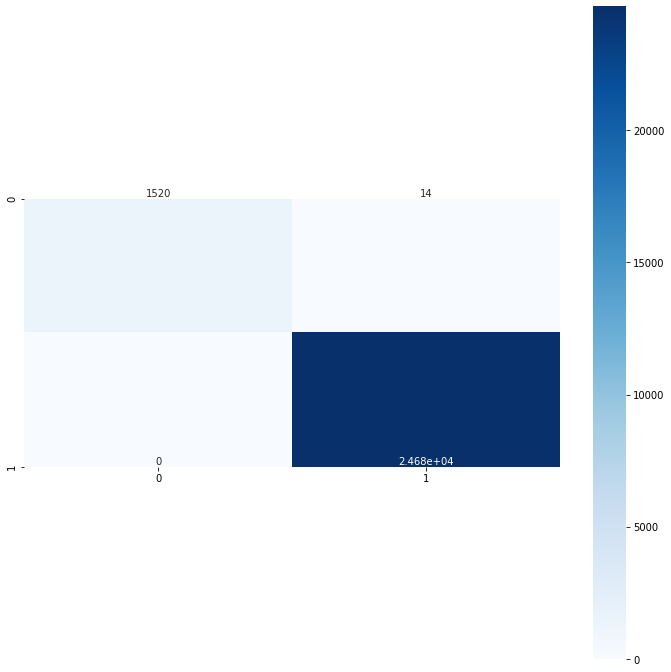

In [30]:
akws = {"ha": 'center',"va": 'bottom'}
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g', annot_kws=akws)